<a href="https://colab.research.google.com/github/js2nijjar/bincrr/blob/main/PortfolioOptimizationandValueatRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
tickers = ['AAPL',  # Apple
          'KO',     # Coca-Cola
          'DIS',    # Disney
          'XOM',    # Exxon Mobil
          'JPM',    # JPMorgan Chase
          'MCD',    # McDonald's
          'WMT']    # Walmart

number_of_shares = [10,20,30,40,50,60,70] # Number of shares in ticker

In [100]:
historical_data = {}

In [101]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import solvers
from cvxopt import matrix
from scipy.stats import norm

In [102]:
for ticker in tickers:
    data = yf.download(ticker, start='2023-01-1', end='2024-08-23')
    historical_data[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [103]:
historical_data

{'AAPL': Date
 2023-01-03    123.904625
 2023-01-04    125.182617
 2023-01-05    123.855087
 2023-01-06    128.412231
 2023-01-09    128.937286
                  ...    
 2024-08-16    226.050003
 2024-08-19    225.889999
 2024-08-20    226.509995
 2024-08-21    226.399994
 2024-08-22    224.529999
 Name: Adj Close, Length: 412, dtype: float64,
 'KO': Date
 2023-01-03    59.665287
 2023-01-04    59.636852
 2023-01-05    58.954426
 2023-01-06    60.091812
 2023-01-09    59.343033
                 ...    
 2024-08-16    68.708961
 2024-08-19    68.510323
 2024-08-20    68.907593
 2024-08-21    69.096298
 2024-08-22    68.857941
 Name: Adj Close, Length: 412, dtype: float64,
 'DIS': Date
 2023-01-03    88.273735
 2023-01-04    91.260178
 2023-01-05    91.200638
 2023-01-06    93.184990
 2023-01-09    94.028336
                 ...    
 2024-08-16    89.300003
 2024-08-19    90.820000
 2024-08-20    89.739998
 2024-08-21    90.720001
 2024-08-22    89.919998
 Name: Adj Close, Length: 412, 

In [104]:
historical_data = pd.DataFrame(historical_data)

In [105]:
historical_data

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
Date,,,,,,,
2023-01-03,123.904625,59.665287,88.273735,100.414612,128.934067,253.880524,46.692341
2023-01-04,125.182617,59.636852,91.260178,100.706863,130.136398,253.938232,46.744350
2023-01-05,123.855087,58.954426,91.200638,102.960091,130.107544,251.796387,46.585030
2023-01-06,128.412231,60.091812,93.184990,104.204552,132.597229,258.817383,47.726318
2023-01-09,128.937286,59.343033,94.028336,102.262451,132.049301,256.685150,47.131290
...,...,...,...,...,...,...,...
2024-08-16,226.050003,68.708961,89.300003,118.169998,213.970001,276.878815,73.449997
2024-08-19,225.889999,68.510323,90.820000,118.529999,215.449997,285.886414,73.720001
2024-08-20,226.509995,68.907593,89.739998,114.580002,214.520004,283.977539,74.540001


In [106]:
simple_daily_returns = historical_data.pct_change()
simple_daily_returns = simple_daily_returns.dropna()
simple_daily_returns

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
Date,,,,,,,
2023-01-04,0.010314,-0.000477,0.033832,0.002910,0.009325,0.000227,0.001114
2023-01-05,-0.010605,-0.011443,-0.000652,0.022374,-0.000222,-0.008435,-0.003408
2023-01-06,0.036794,0.019293,0.021758,0.012087,0.019136,0.027884,0.024499
2023-01-09,0.004089,-0.012461,0.009050,-0.018637,-0.004132,-0.008238,-0.012468
2023-01-10,0.004456,-0.007666,0.008336,0.014935,0.008954,0.006211,-0.000621
...,...,...,...,...,...,...,...
2024-08-16,0.005918,0.007720,0.005744,-0.004717,0.011439,0.013170,0.006550
2024-08-19,-0.000708,-0.002891,0.017021,0.003046,0.006917,0.032533,0.003676
2024-08-20,0.002745,0.005799,-0.011892,-0.033325,-0.004317,-0.006677,0.011123


In [107]:
log_daily_returns = np.log(historical_data/historical_data.shift(1))
log_daily_returns = log_daily_returns.dropna()
log_daily_returns

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
Date,,,,,,,
2023-01-04,0.010261,-0.000477,0.033272,0.002906,0.009282,0.000227,0.001113
2023-01-05,-0.010661,-0.011509,-0.000653,0.022127,-0.000222,-0.008470,-0.003414
2023-01-06,0.036133,0.019109,0.021525,0.012014,0.018955,0.027502,0.024204
2023-01-09,0.004080,-0.012539,0.009010,-0.018813,-0.004141,-0.008272,-0.012546
2023-01-10,0.004446,-0.007696,0.008301,0.014824,0.008914,0.006192,-0.000621
...,...,...,...,...,...,...,...
2024-08-16,0.005901,0.007691,0.005727,-0.004728,0.011374,0.013084,0.006529
2024-08-19,-0.000708,-0.002895,0.016878,0.003042,0.006893,0.032015,0.003669
2024-08-20,0.002741,0.005782,-0.011963,-0.033893,-0.004326,-0.006699,0.011062


In [108]:
historical_mean = log_daily_returns.mean().to_frame()
historical_mean

,0
AAPL,0.001446
KO,0.000349
DIS,0.000045
XOM,0.000324
JPM,0.001263
MCD,0.000303
WMT,0.001172


In [109]:
historical_variance = log_daily_returns.var().to_frame().T
historical_variance

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
0,0.000189,0.000067,0.000292,0.000203,0.000167,0.000102,0.00011


In [110]:
historical_covariance = log_daily_returns.cov()
historical_covariance

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
AAPL,0.000189,0.000017,0.000047,0.000008,0.000028,0.000027,0.000017
KO,0.000017,0.000067,0.000008,0.000017,0.000021,0.000041,0.000029
DIS,0.000047,0.000008,0.000292,0.000058,0.000060,0.000031,0.000019
XOM,0.000008,0.000017,0.000058,0.000203,0.000066,0.000026,0.000018
JPM,0.000028,0.000021,0.000060,0.000066,0.000167,0.000031,0.000019
MCD,0.000027,0.000041,0.000031,0.000026,0.000031,0.000102,0.000023
WMT,0.000017,0.000029,0.000019,0.000018,0.000019,0.000023,0.000110


In [111]:
historical_correlation = log_daily_returns.corr()
historical_correlation

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
AAPL,1.000000,0.147179,0.198196,0.040821,0.156467,0.194268,0.114811
KO,0.147179,1.000000,0.055801,0.142815,0.194925,0.500059,0.343324
DIS,0.198196,0.055801,1.000000,0.239283,0.270289,0.180740,0.103485
XOM,0.040821,0.142815,0.239283,1.000000,0.356938,0.180751,0.118798
JPM,0.156467,0.194925,0.270289,0.356938,1.000000,0.239059,0.136668
MCD,0.194268,0.500059,0.180740,0.180751,0.239059,1.000000,0.219413
WMT,0.114811,0.343324,0.103485,0.118798,0.136668,0.219413,1.000000


In [112]:
# Value at Risk
dollar_value_of_holdings = historical_data*number_of_shares
dollar_value_of_holdings

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
Date,,,,,,,
2023-01-03,1239.046249,1193.305740,2648.212051,4016.584473,6446.703339,15232.831421,3268.463860
2023-01-04,1251.826172,1192.737045,2737.805328,4028.274536,6506.819916,15236.293945,3272.104530
2023-01-05,1238.550873,1179.088516,2736.019135,4118.403625,6505.377197,15107.783203,3260.952072
2023-01-06,1284.122314,1201.836243,2795.549698,4168.182068,6629.861450,15529.042969,3340.842285
2023-01-09,1289.372864,1186.860657,2820.850067,4090.498047,6602.465057,15401.109009,3299.190331
...,...,...,...,...,...,...,...
2024-08-16,2260.500031,1374.179230,2679.000092,4726.799927,10698.500061,16612.728882,5141.499786
2024-08-19,2258.899994,1370.206451,2724.599991,4741.199951,10772.499847,17153.184814,5160.400085
2024-08-20,2265.099945,1378.151855,2692.199936,4583.200073,10726.000214,17038.652344,5217.800064


In [113]:
dollar_value_of_holdings_end_date = dollar_value_of_holdings.iloc[-1]
dollar_value_of_holdings_end_date.values
dollar_value_of_holdings_end_date

,2024-08-22
AAPL,2245.299988
KO,1377.158813
DIS,2697.599945
XOM,4589.200134
JPM,10831.500244
MCD,17252.208252
WMT,5290.600128


In [114]:
dollar_value_of_the_portfolio = np.sum(dollar_value_of_holdings_end_date)
dollar_value_of_the_portfolio

44283.56750488281

In [115]:
# z value
z = norm.ppf(0.95, 0, 1) # 95% confidence with mean 0 and variance 1
z

1.6448536269514722

In [116]:
standard_deviation_portfolio = np.sqrt(np.dot(dollar_value_of_holdings_end_date.values.T, np.dot(historical_covariance, dollar_value_of_holdings_end_date.values))) # in $
standard_deviation_portfolio

326.247338087474

In [117]:
value_at_risk_portfolio = z * standard_deviation_portfolio # in $
value_at_risk_portfolio

536.6291173364448

In [118]:
standard_deviation_i = np.sqrt(np.diag(historical_covariance))
standard_deviation_i

array([0.01375488, 0.00815485, 0.01707531, 0.01423545, 0.01292547,
       0.01010905, 0.01050358])

In [119]:
value_at_risk_i = z * standard_deviation_i * dollar_value_of_holdings_end_date.values # in $
value_at_risk_i

array([ 50.79937928,  18.47255793,  75.76581829, 107.45715905,
       230.28311485, 286.86814828,  91.40492671])

In [120]:
covariance_ip = np.dot(historical_covariance, dollar_value_of_holdings_end_date.values)/(dollar_value_of_the_portfolio)
covariance_ip

array([3.30797772e-05, 2.96955615e-05, 5.53536828e-05, 5.37847175e-05,
       6.77393029e-05, 5.74841732e-05, 3.15223860e-05])

In [121]:
beta_ip = covariance_ip / ((standard_deviation_portfolio*standard_deviation_portfolio)/(dollar_value_of_the_portfolio*dollar_value_of_the_portfolio))
beta_ip

array([0.60947209, 0.54712025, 1.01985345, 0.99094634, 1.24804996,
       1.05910626, 0.58077823])

In [122]:
marginal_value_at_risk_i = (value_at_risk_portfolio / dollar_value_of_the_portfolio)*beta_ip
marginal_value_at_risk_i

array([0.00738559, 0.00663001, 0.0123586 , 0.01200831, 0.01512389,
       0.01283427, 0.00703788])

In [123]:
component_value_at_risk_i = marginal_value_at_risk_i * dollar_value_of_holdings_end_date.values # in $
component_value_at_risk_i

array([ 16.58287511,   9.13058173,  33.33856827,  55.10852285,
       163.81445349, 221.41949796,  37.23461792])

In [125]:
component_value_at_risk_i_dataframe = pd.DataFrame(data = np.column_stack((dollar_value_of_holdings_end_date, dollar_value_of_holdings_end_date/dollar_value_of_the_portfolio, component_value_at_risk_i, component_value_at_risk_i/value_at_risk_portfolio, beta_ip )))
component_value_at_risk_i_dataframe.index = tickers
component_value_at_risk_i_dataframe.columns = ['Position ($)', 'Position (%)','CVaR ($)','CVaR (%)', 'Beta']
component_value_at_risk_i_dataframe

,Position ($),Position (%),CVaR ($),CVaR (%),Beta
AAPL,2245.299988,0.050703,16.582875,0.030902,0.609472
KO,1377.158813,0.031099,9.130582,0.017015,0.547120
DIS,2697.599945,0.060917,33.338568,0.062126,1.019853
XOM,4589.200134,0.103632,55.108523,0.102694,0.990946
JPM,10831.500244,0.244594,163.814453,0.305266,1.248050
MCD,17252.208252,0.389585,221.419498,0.412612,1.059106
WMT,5290.600128,0.119471,37.234618,0.069386,0.580778


In [126]:
number_of_portfolios = 5000
number_of_portfolios

5000

In [127]:
portfolio_returns = np.zeros(number_of_portfolios)
portfolio_returns

array([0., 0., 0., ..., 0., 0., 0.])

In [128]:
portfolio_standard_deviations = np.zeros(number_of_portfolios)
portfolio_standard_deviations

array([0., 0., 0., ..., 0., 0., 0.])

In [129]:
for index in range(number_of_portfolios):
    weights = np.random.rand(len(tickers))
    weights = weights / sum(weights)
    portfolio_return = np.dot(weights.T, historical_mean.values.flatten()) * 252
    portfolio_standard_deviation = np.sqrt(np.dot(weights.T, np.dot(historical_covariance, weights))) * np.sqrt(252)
    portfolio_returns[index] = portfolio_return
    portfolio_standard_deviations[index] = portfolio_standard_deviation

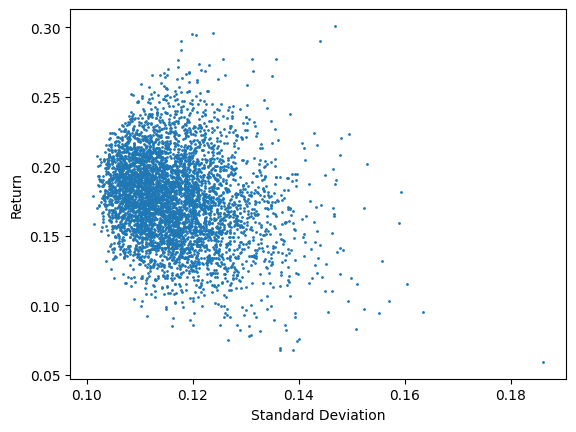

In [130]:
plt.plot(portfolio_standard_deviations, portfolio_returns, 'o', markersize = 1)
plt.xlabel('Standard Deviation')
plt.ylabel('Return')
plt.show()
# 5000 portfolios with randomly generated weights. As you can see asset allocation makes a big difference.

In [131]:
# Global Minimum Variance
historical_covariance_inverse = -np.linalg.inv(historical_covariance)
historical_covariance_inverse

array([[ -5743.20376178,    524.46551964,    738.98192553,
          -359.0291452 ,    556.36028431,    917.96696539,
           369.75953186],
       [   524.46551964, -22021.27229565,   -838.02111138,
           391.53407737,    871.49461179,   7700.52192467,
          4096.22017025],
       [   738.98192553,   -838.02111138,  -3969.80406533,
           749.30325332,    914.6695362 ,    807.97797667,
           335.02661362],
       [  -359.0291452 ,    391.53407737,    749.30325332,
         -5889.07102501,   1920.34608412,    544.06948769,
           333.87998238],
       [   556.36028431,    871.49461179,    914.6695362 ,
          1920.34608412,  -7476.29521316,    955.51613126,
           276.57980947],
       [   917.96696539,   7700.52192467,    807.97797667,
           544.06948769,    955.51613126, -13893.45979415,
           359.06320084],
       [   369.75953186,   4096.22017025,    335.02661362,
           333.87998238,    276.57980947,    359.06320084,
        -10444.020

In [132]:
one_vector = np.ones(len(tickers))
one_vector

array([1., 1., 1., 1., 1., 1., 1.])

In [133]:
global_minimum_variance_weights = np.dot(historical_covariance_inverse, one_vector) / np.dot(one_vector.T, np.dot(historical_covariance_inverse, one_vector))
global_minimum_variance_weights

array([0.11929287, 0.36946894, 0.05026602, 0.09197698, 0.0789256 ,
       0.10390256, 0.18616704])

In [134]:
global_minimum_variance_weights_dataframe = pd.DataFrame(global_minimum_variance_weights).T
global_minimum_variance_weights_dataframe.columns = tickers
global_minimum_variance_weights_dataframe

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
0,0.119293,0.369469,0.050266,0.091977,0.078926,0.103903,0.186167


In [135]:
global_minimum_variance_standard_deviation = np.sqrt(np.dot(global_minimum_variance_weights.T, np.dot(historical_covariance, global_minimum_variance_weights))) * np.sqrt(252)
global_minimum_variance_standard_deviation

0.10019151485872169

In [136]:
# Maximum Return
mu_0 = np.max(historical_mean)
mu_0

0.0014464652242600485

In [137]:
y = np.matrix([mu_0, 1]).T
y.shape

(2, 1)

In [138]:
B = np.hstack((historical_mean.values, one_vector.reshape(len(tickers),1)))
B.shape

(7, 2)

In [139]:
A = np.matrix([[np.dot(historical_mean.values.T,np.dot(historical_covariance_inverse, historical_mean.values)).item(),np.dot(historical_mean.values.T,np.dot(historical_covariance_inverse,one_vector.reshape(len(tickers),1))).item()],[np.dot(historical_mean.values.T,np.dot(historical_covariance_inverse,one_vector.reshape(len(tickers),1))).item(),np.dot(one_vector.reshape(len(tickers),1).T,np.dot(historical_covariance_inverse,one_vector.reshape(len(tickers),1))).item()]])
A.shape

(2, 2)

In [140]:
weights_maximum_return = np.dot(historical_covariance_inverse, np.dot(B, np.dot(np.linalg.inv(A), y)))
weights_maximum_return

matrix([[ 0.33203298],
        [ 0.02299185],
        [-0.10627735],
        [-0.01096155],
        [ 0.33425552],
        [-0.04951502],
        [ 0.47747357]])

In [141]:
weights_maximum_return_dataframe = pd.DataFrame(weights_maximum_return.T)
weights_maximum_return_dataframe.columns = tickers
weights_maximum_return_dataframe

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
0,0.332033,0.022992,-0.106277,-0.010962,0.334256,-0.049515,0.477474


In [142]:
N = 100
efficient_frontier_left = np.min(historical_mean)
efficient_frontier_right = np.max(historical_mean)
efficient_frontier_target_returns = np.linspace(efficient_frontier_left, efficient_frontier_right, N)

In [143]:
efficient_frontier_left

4.4958038352890124e-05

In [144]:
efficient_frontier_right

0.0014464652242600485

In [145]:
efficient_frontier_target_returns

array([4.49580384e-05, 5.91146766e-05, 7.32713148e-05, 8.74279531e-05,
       1.01584591e-04, 1.15741230e-04, 1.29897868e-04, 1.44054506e-04,
       1.58211144e-04, 1.72367783e-04, 1.86524421e-04, 2.00681059e-04,
       2.14837697e-04, 2.28994335e-04, 2.43150974e-04, 2.57307612e-04,
       2.71464250e-04, 2.85620888e-04, 2.99777527e-04, 3.13934165e-04,
       3.28090803e-04, 3.42247441e-04, 3.56404080e-04, 3.70560718e-04,
       3.84717356e-04, 3.98873994e-04, 4.13030633e-04, 4.27187271e-04,
       4.41343909e-04, 4.55500547e-04, 4.69657186e-04, 4.83813824e-04,
       4.97970462e-04, 5.12127100e-04, 5.26283739e-04, 5.40440377e-04,
       5.54597015e-04, 5.68753653e-04, 5.82910292e-04, 5.97066930e-04,
       6.11223568e-04, 6.25380206e-04, 6.39536844e-04, 6.53693483e-04,
       6.67850121e-04, 6.82006759e-04, 6.96163397e-04, 7.10320036e-04,
       7.24476674e-04, 7.38633312e-04, 7.52789950e-04, 7.66946589e-04,
       7.81103227e-04, 7.95259865e-04, 8.09416503e-04, 8.23573142e-04,
      

In [146]:
weights_maximum_return

matrix([[ 0.33203298],
        [ 0.02299185],
        [-0.10627735],
        [-0.01096155],
        [ 0.33425552],
        [-0.04951502],
        [ 0.47747357]])

In [147]:
# max_weight = 0.2
# P = matrix(historical_covariance.values)
# q = matrix(np.zeros((len(tickers),1)))
# S = matrix(np.hstack((historical_mean.values,one_vector.reshape(len(tickers),1))).T)
# b = matrix([mu_0, 1])
# G = matrix(-np.eye(len(tickers)))
# G = matrix(np.vstack((-np.eye(len(tickers)), np.eye(len(tickers)))))
# h = matrix(np.zeros((len(tickers),1)))
# h = matrix(np.vstack((np.zeros((len(tickers), 1)), max_weight*one_vector.reshape(len(tickers), 1))))
# solution = solvers.qp(P, q, A=S, b=b, G=G, h=h)
# solution = solvers.qp(P, q, A=S, b=b)
# efficient_frontier_weights = np.array(solution['x'])
# efficient_frontier_weights_dataframe = pd.DataFrame(efficient_frontier_weights.T)
# efficient_frontier_weights_dataframe.columns = tickers
# efficient_frontier_weights_dataframe

In [148]:
P = matrix(historical_covariance.values)
q = matrix(np.zeros((len(tickers),1)))
S = matrix(np.hstack((historical_mean.values,one_vector.reshape(len(tickers),1))).T)
efficient_frontier_weights = [solvers.qp(P, q, A=S, b=matrix([t, 1]))['x'] for t in efficient_frontier_target_returns]
efficient_frontier_returns = [(np.dot(w.T, historical_mean.values.flatten())*250).item() for w in efficient_frontier_weights]
efficient_frontier_standard_deviation = [(np.sqrt(np.dot(w.T, np.dot(historical_covariance, w)) * 250)).item() for w in efficient_frontier_weights]
efficient_frontier_weights_dataframe = pd.DataFrame(efficient_frontier_weights)
efficient_frontier_weights_dataframe.columns = tickers
efficient_frontier_weights_dataframe_positive = efficient_frontier_weights_dataframe.where(efficient_frontier_weights_dataframe > 0)
efficient_frontier_weights_dataframe_positive = efficient_frontier_weights_dataframe_positive.dropna()
efficient_frontier_weights_dataframe_positive.shape[0]

34

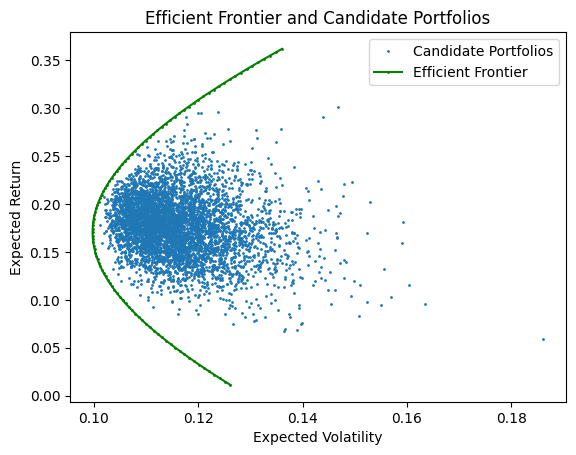

In [149]:
plt.plot(portfolio_standard_deviations, portfolio_returns, 'o', markersize=1, label='Candidate Portfolios')
plt.plot(efficient_frontier_standard_deviation, efficient_frontier_returns, 'o-', color='green', markersize=1, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Candidate Portfolios')
plt.legend(loc='best')
plt.show()

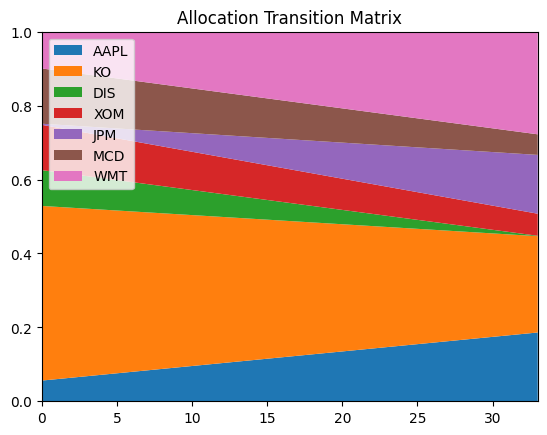

In [150]:
# Transition Matrix
plt.stackplot(range(efficient_frontier_weights_dataframe_positive.shape[0]), efficient_frontier_weights_dataframe_positive.T, labels=tickers)
plt.legend(loc='upper left')
plt.margins(0, 0)
plt.title('Allocation Transition Matrix')
plt.show()

In [151]:
# Maximum Sharpe
annualized_risk_free_rate = 0.04615
daily_risk_free_rate = annualized_risk_free_rate/252
weights_sharpe_ratio = np.dot(historical_covariance_inverse, historical_mean.values-daily_risk_free_rate*one_vector.reshape(len(tickers),1)) / np.dot(one_vector.reshape(len(tickers),1).T, np.dot(historical_covariance_inverse, historical_mean.values-daily_risk_free_rate*one_vector.reshape(len(tickers),1)))
weights_sharpe_ratio.shape

(7, 1)

In [152]:
weights_sharpe_ratio_dataframe = pd.DataFrame(weights_sharpe_ratio.T)
weights_sharpe_ratio_dataframe.columns = tickers
weights_sharpe_ratio_dataframe

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
0,0.49799,-0.247293,-0.228396,-0.091263,0.533437,-0.169195,0.70472


In [153]:
sharpe_ratio_returns = np.dot(weights_sharpe_ratio.T, historical_mean.values) * 252
share_ratio_standard_deviation = np.sqrt(np.dot(weights_sharpe_ratio.T, np.dot(historical_covariance, weights_sharpe_ratio))) * np.sqrt(252)

In [154]:
sharpe_ratio_returns.item()

0.514649160453897

In [155]:
share_ratio_standard_deviation.item()

0.19327717209305295

In [156]:
sharpe_ratio = (sharpe_ratio_returns.item() - annualized_risk_free_rate) / share_ratio_standard_deviation.item()
sharpe_ratio

2.423975658275561